In [1]:
# 导入数据
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from matplotlib import pyplot as plt
import numpy as np

from scipy import  stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller   # 平稳性检验
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pmdarima as pm
from pmdarima import auto_arima
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error

In [3]:
from sklearn import preprocessing

scaler =preprocessing.MinMaxScaler()

In [4]:
data = pd.read_csv(r'library\csv\pm\beijing_final1.csv')

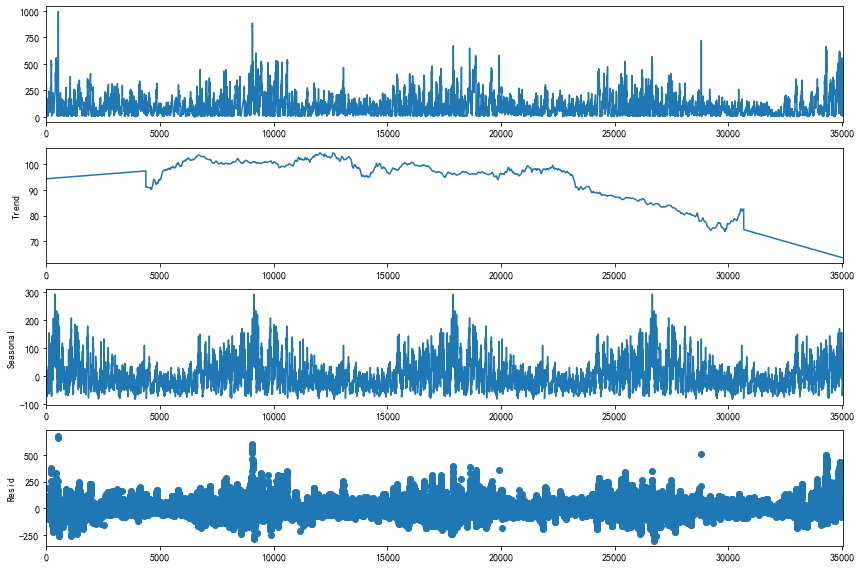

In [7]:
import statsmodels.api as sm

#data指你自己的时序数据，model='additive'代表是加法模式，
#extrapolate_trend='freq'表示trend 、resid频率会从最近点开始，并且会对最近点的缺失值进行填充
#更多参数设置请参考官方文档：https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(data, model='additive', extrapolate_trend='freq',period=8760)  
plt.rc('figure',figsize=(12,8))
fig = decomposition.plot()
plt.show()

In [5]:
y = np.array(data['Value'].values).reshape(-1,1)
x = np.arange(len(y)).reshape(-1,1)
y_normalized = scaler.fit_transform(y)

In [6]:
data['Value'] =  pd.DataFrame(y_normalized)
data['Value']

0       0.299616
1       0.294494
2       0.304738
3       0.261204
4       0.212548
          ...   
8780    0.522407
8781    0.551857
8782    0.615877
8783    0.623560
8784    0.647887
Name: Value, Length: 8785, dtype: float64

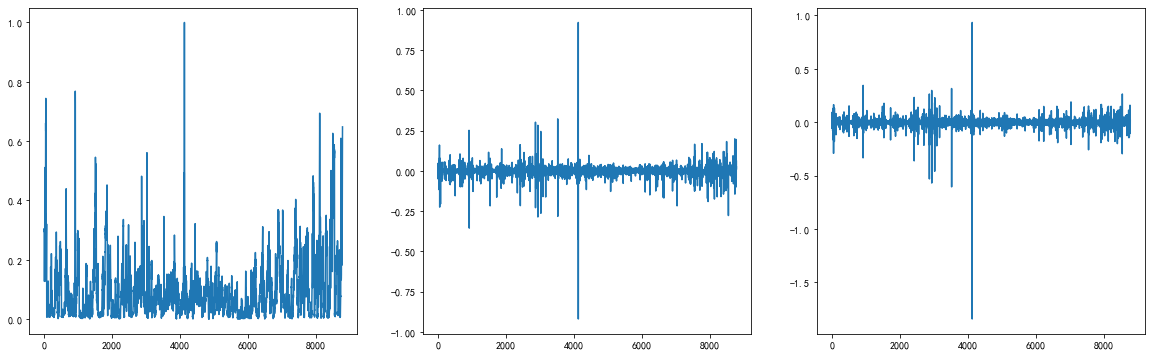

In [7]:
data['Close_diff_1'] = data['Value'].diff(1)
data['Close_diff_2'] = data['Close_diff_1'].diff(1)

fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
ax1.plot(data['Value'])
ax2 = fig.add_subplot(132)
ax2.plot(data['Close_diff_1'])
ax3 = fig.add_subplot(133)
ax3.plot(data['Close_diff_2'])
plt.show()

The ADF Statistic: -29.021790
The p value: 0.000000


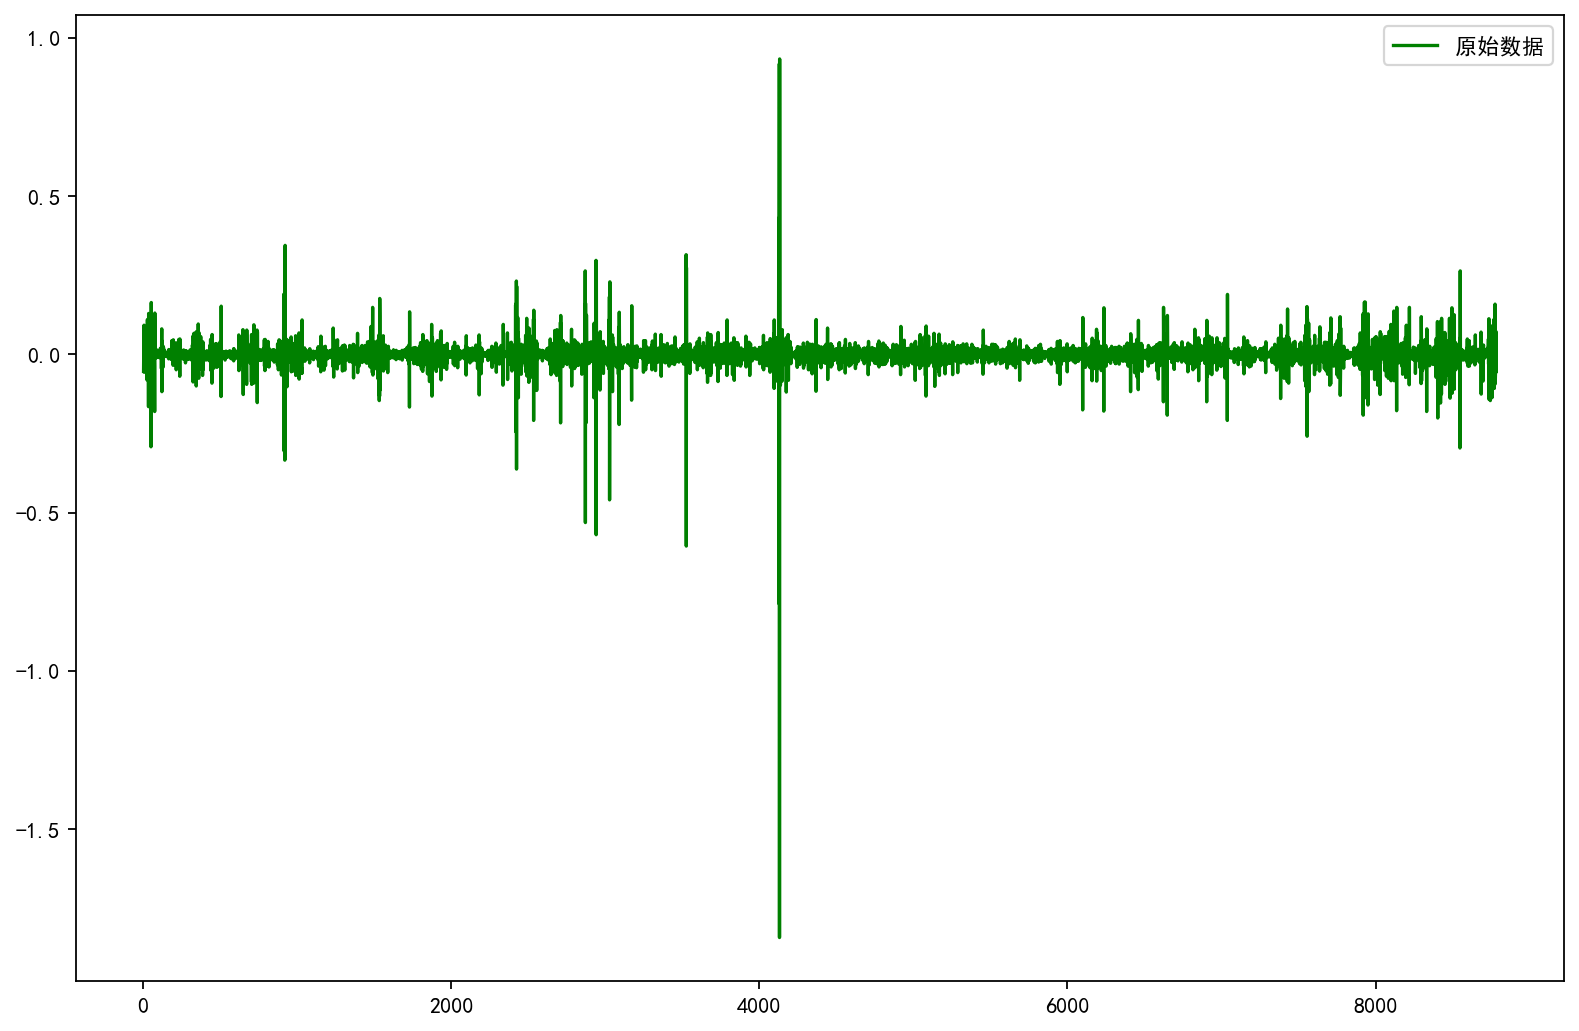

In [8]:
new_data = data['Close_diff_2'][3:]
adfuller_result = adfuller(new_data)
print('The ADF Statistic: %f' % adfuller_result[0])
print('The p value: %f' % adfuller_result[1])


plt.figure(figsize=(12,8),dpi=160)
plt.plot(new_data,color='green',label = '原始数据')
plt.legend()
plt.show()

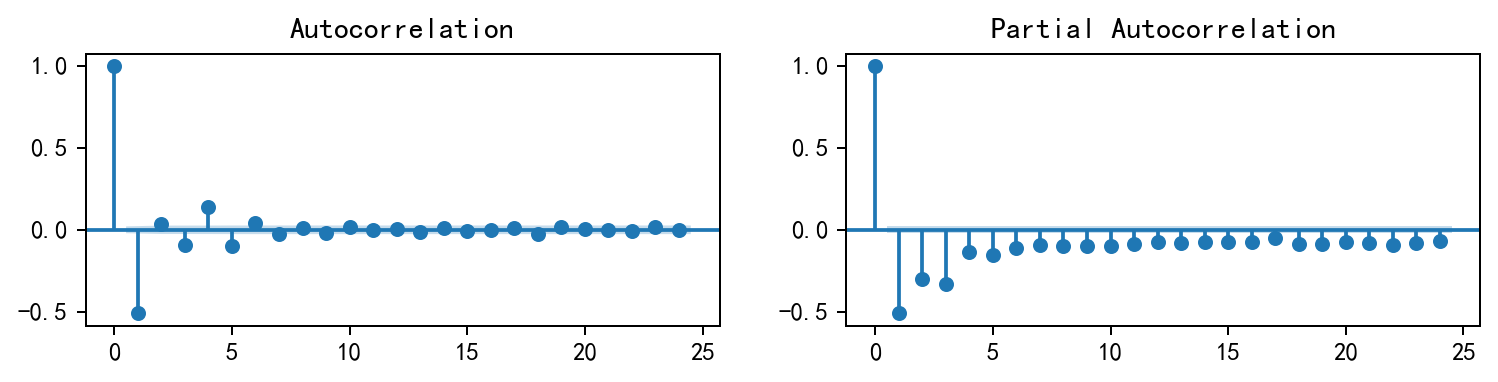

In [9]:
# ARMA模型检验
fig=plt.figure(figsize=(10,2),dpi=180)
# ACF图
ax1=fig.add_subplot(121)
fig=sm.graphics.tsa.plot_acf(new_data,lags=24, ax=ax1) 

# PACF图
ax2=fig.add_subplot(122)
fig=sm.graphics.tsa.plot_pacf(new_data,lags=24, ax=ax2)

In [10]:
train, test = model_selection.train_test_split(y_normalized, train_size=8000)
# 确定训练集、测试集这个函数可以记住model_selection.train_test_spilt 用来分割train和test


In [11]:
modl = pm.auto_arima(train,
                     start_p=1,  # p最小值
                     start_q=1,  # q最小值
                     start_P=1,
                     start_Q=1,
                     max_p=6,  # p最大值
                     max_q=6,  # q最大值
                     max_P=6,
                     max_Q=6,
                     seasonal=True,
                     stepwise=True,  # 当stepwise为False是则不进行完全组合遍历
                     suppress_warnings=True, D=5, max_D=5,
                     error_action='ignore'
                     )

In [12]:
modl

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

In [14]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))  # RMSE

Test RMSE: 0.180


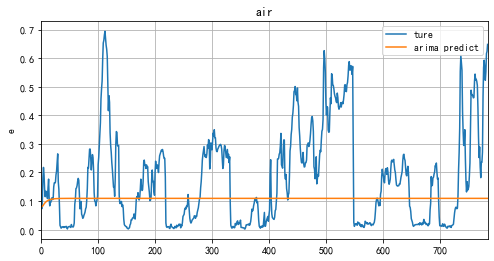

In [16]:
x = np.arange(len(test))
plt.figure(figsize=(8,4))

plt.title('air')
plt.ylabel('e')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test)
plt.plot(x,preds)

plt.legend(['ture','arima predict'])
plt.show()